info at https://www.kaggle.com/datasets/openfoodfacts/world-food-facts

# Imports

In [3]:
import io
import shutil
import glob
import requests
from zipfile import ZipFile
from tempfile import mkdtemp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sns.set()

### fonctions

In [4]:
# Chargement du dataset csv depuis un zip en ligne
def load(url: str) -> pd.DataFrame:
    # Request zip on AWS
    print(f'load data from {url}')
    response = requests.get(url)

    # Unzip file
    tempDir = mkdtemp()
    print(f'extract to temp dir: {tempDir}')

    with ZipFile(io.BytesIO(response.content), 'r') as zip_ref:
        zip_ref.extractall(tempDir)

    csv = glob.glob(tempDir + '\*.csv')[0]

    # Read it in pandas
    print('Read csv by pandas')
    df = pd.read_csv(csv, delimiter='\t',
                     parse_dates=True,
                     low_memory=False)

    # Delete temp directory
    print('Delete temp Dir')
    shutil.rmtree(tempDir, ignore_errors=True)

    print('Dataset ready to explore under name: "df"!')
    return df

# Affichage des infos du dataset
def infos(df: pd.DataFrame):
    memory_gb = np.round(df.memory_usage(deep=True).sum()/(1024**3),2)
    nb_lignes = df.shape[0]
    nb_columns = df.shape[1]
    print(f'A ce stade le dataset contient {nb_lignes} lignes et {nb_columns} colonnes. (conso mémoire {memory_gb}Gb)')

# Extraction d'une serie depuis un champ contenant une liste
def extract_serie(dataFrame: pd.DataFrame, column: str) -> pd.Series:
    words = pd.Series(dtype=np.int32)
    for value in dataFrame.loc[:, column].dropna():
        splitted_values = value.split(',')
        for splitted_value in splitted_values:
            if splitted_value in words.keys():
                words[splitted_value] += 1
            else:
                words[splitted_value] = 0
    
    return words.sort_values(ascending=False)        

# Scaler de données
def scale(values: np.ndarray) -> np.ndarray:
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(values)
    pd.DataFrame(scaled_values).describe().round(2)
    return scaled_values

# Acp
def acp(scaled_values: np.ndarray, n_components = 2) -> {'pca': PCA, 'X_proj': np.ndarray}:
    pca = PCA(n_components=n_components)
    pca.fit(scaled_values)
    return {'pca': pca, 'X_proj': pca.transform(scaled_values)}

# Affichage de 'éboulie des valeurs propres
def acp_eboulis(pca: PCA):
    scree = (pca.explained_variance_ratio_*100).round(2)
    scree_cum = scree.cumsum()
    x = range(1, len(scree)+1)
    plt.bar(height=scree, x=x)
    plt.plot(x, scree_cum, '-o', c='r')

# Lecture du dataset

In [5]:
url = 'https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip'    
df = load(url)

load data from https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip
extract to temp dir: C:\Users\gagno\AppData\Local\Temp\tmp5c22sw5j
Read csv by pandas
Delete temp Dir
Dataset ready to explore under name: "df"!


# Description rapide

Apperçu du dataset

In [6]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
infos(df)

A ce stade le dataset contient 320772 lignes et 162 colonnes. (conso mémoire 1.72Gb)


# Nettoyage

### Suppression des colonnes inutiles

Je décide de supprimer les colonnes contenant des url et celles qui concernent les dates et createur

In [8]:
url_columns = df.columns[df.columns.str.contains('url')].to_list()
unused_columns = ['creator',
                  'created_t',
                  'created_datetime',
                  'last_modified_t',
                  'last_modified_datetime'
                 ]
df = df.drop(url_columns + unused_columns, axis=1)

### Visualisation des taux de remplissage

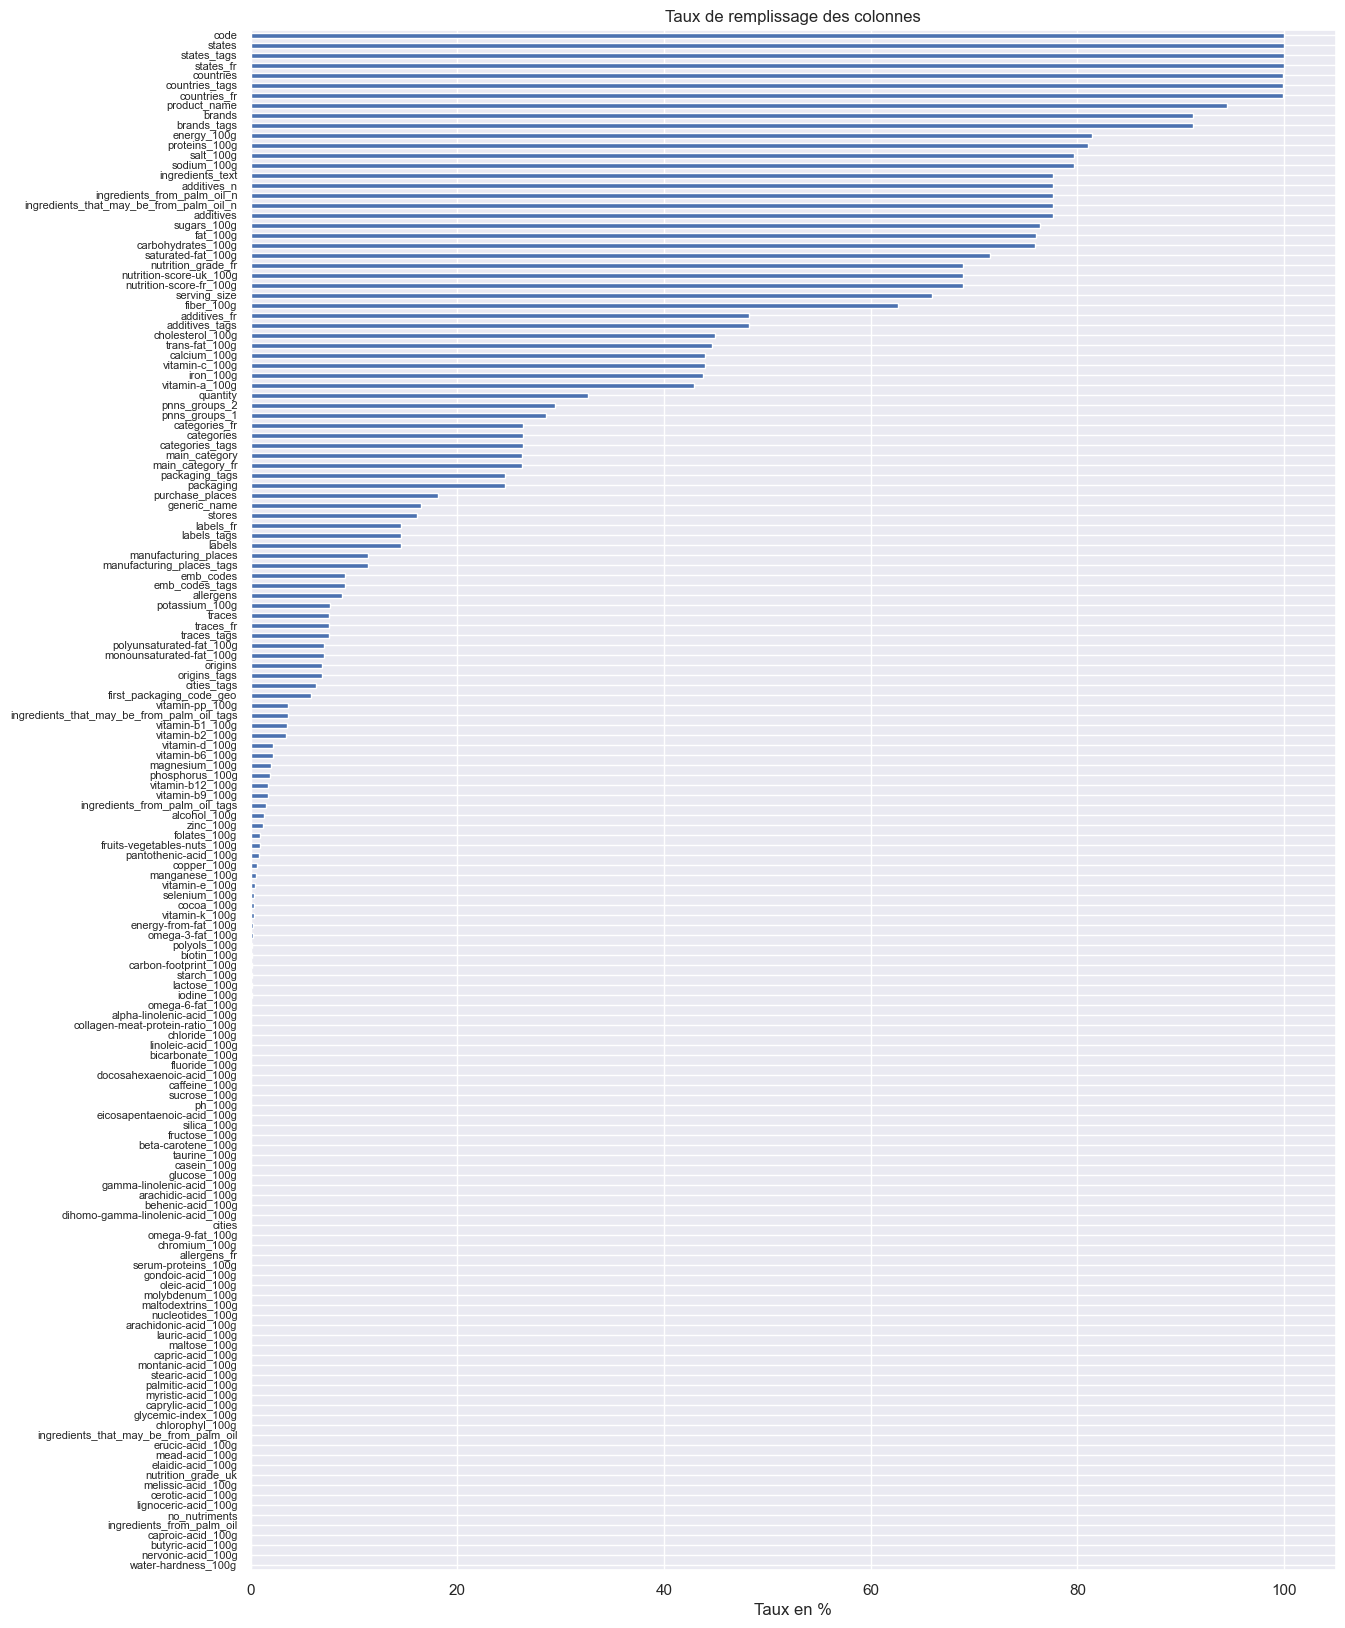

In [9]:
taux = (1 - df.isna().mean().sort_values(ascending=False))*100
figure = plt.figure(figsize=(14,20))
taux.plot.barh()
plt.yticks(fontsize=8)
plt.title('Taux de remplissage des colonnes')
plt.xlabel('Taux en %')
plt.show()

Des colonnes sont très vides. On va supprimer toutes les colonnes pour lesquelles le nombre de produits représentés est inférieur à 1000

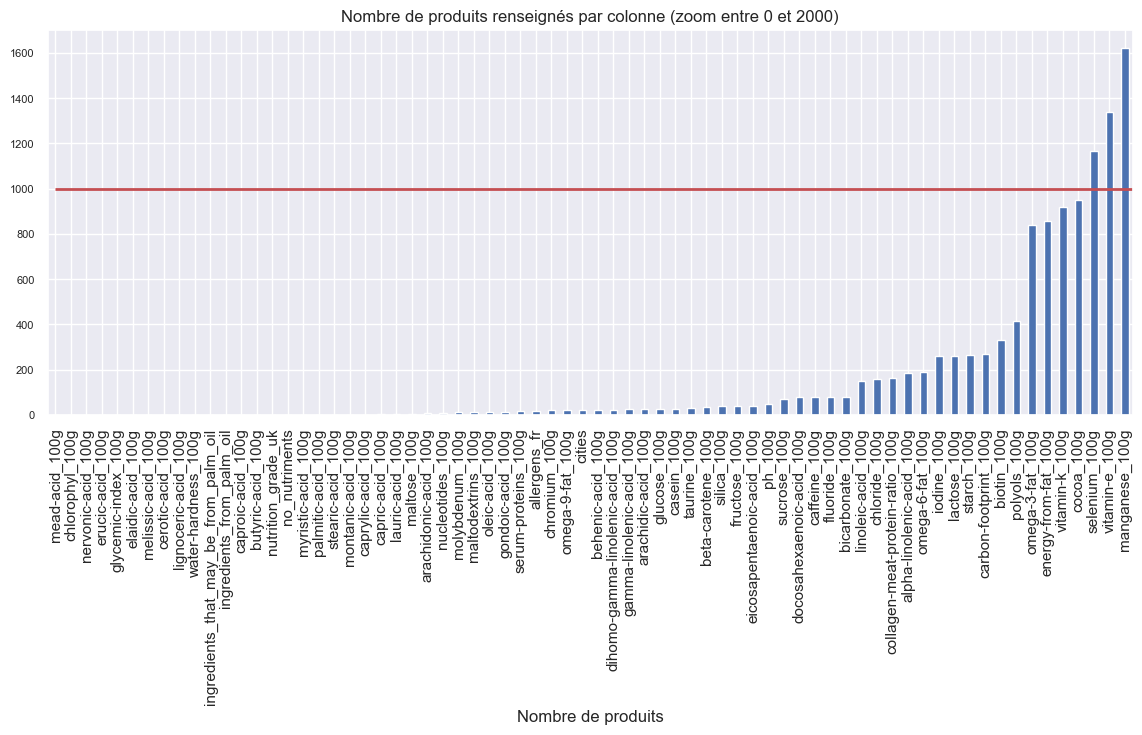

In [10]:
column_nb_values = len(df) - df.isna().sum()
figure = plt.figure(figsize=(14,5))
column_nb_values.loc[column_nb_values < 2000].sort_values().plot.bar()
plt.yticks(fontsize=8)
plt.title('Nombre de produits renseignés par colonne (zoom entre 0 et 2000)')
plt.xlabel('Nombre de produits')
plt.hlines(y=1000, xmin=0, xmax=100, colors='r', linewidths=2)
plt.show()

In [11]:
df = df.loc[:, column_nb_values > 1000]
infos(df)

A ce stade le dataset contient 320772 lignes et 87 colonnes. (conso mémoire 1.36Gb)


### Suppression des lignes ne contenant pas de code

In [12]:
code_na_filter = df['code'].isna()
print(f'Nombre de lignes concernées: {len(df.loc[code_na_filter, :])}')
df = df.loc[~df['code'].isna(), :]

Nombre de lignes concernées: 23


### Suppression des lignes ne contenant aucune information de nutrition
Les lignes qui ne contiennent aucune information de nutrition sont celles pour lesquelles aucune colonne _100g n'est remplie

In [13]:
nutrition_columns = df.columns[df.columns.str.endswith('_100g') & ~df.columns.str.contains('energy')]
empties_line_filter = df.loc[:, nutrition_columns].sum(axis=1) == 0
print(f'Nombre de lignes concernées: {len(df.loc[empties_line_filter,:])}')
df = df.loc[~empties_line_filter, :]

Nombre de lignes concernées: 59276


 ### Suppression des lignes qui contiennent des valeurs de nutrition aberrantes (_100g < 0 ou _100g > 100)

In [14]:
# clean _100 < 0
negative_filter = (df.loc[:, nutrition_columns] < 0).sum(axis=1)
nb_negatives = len(df.loc[negative_filter > 0, :])
print(f'{nb_negatives} lignes contiennent une valeur nutritionnelle < 0')
df = df.loc[negative_filter == 0, :]

# clean _100 > 100
upper_100g = (df.loc[:, nutrition_columns] > 100).sum(axis=1)
nb_upper_100 = len(df.loc[upper_100g > 0, :])
print(f'{nb_upper_100} lignes contiennent une valeur nutritionnelle > 100')
df = df.loc[upper_100g == 0, :]

infos(df)

37372 lignes contiennent une valeur nutritionnelle < 0
207 lignes contiennent une valeur nutritionnelle > 100
A ce stade le dataset contient 223894 lignes et 87 colonnes. (conso mémoire 1.01Gb)


### Mise à 0 des colonnes numeriques avec un faible taux de remplissage (< 60%)

In [15]:
numeric_cols = df.select_dtypes('number').columns
numeric_cols

Index(['additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'monounsaturated-fat_100g',
       'polyunsaturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'alcohol_100g', 'vitamin-a_100g',
       'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-c_100g', 'vitamin-b1_100g',
       'vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g',
       'vitamin-b9_100g', 'folates_100g', 'vitamin-b12_100g',
       'pantothenic-acid_100g', 'potassium_100g', 'calcium_100g',
       'phosphorus_100g', 'iron_100g', 'magnesium_100g', 'zinc_100g',
       'copper_100g', 'manganese_100g', 'selenium_100g',
       'fruits-vegetables-nuts_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g'],
      dtype='object')

In [16]:
for col in numeric_cols:
    if df.loc[:, col].isna().mean() >= 0.6:
        df.loc[df[col].isna(), col] = 0
    
df.loc[:, numeric_cols].isna().mean().sort_values(ascending=False)

vitamin-a_100g                             0.482246
iron_100g                                  0.472344
vitamin-c_100g                             0.470267
calcium_100g                               0.469521
trans-fat_100g                             0.458887
cholesterol_100g                           0.457167
fiber_100g                                 0.263424
nutrition-score-fr_100g                    0.182859
nutrition-score-uk_100g                    0.182859
saturated-fat_100g                         0.145890
additives_n                                0.105197
ingredients_that_may_be_from_palm_oil_n    0.105197
ingredients_from_palm_oil_n                0.105197
sugars_100g                                0.082066
carbohydrates_100g                         0.082030
fat_100g                                   0.080650
sodium_100g                                0.040939
salt_100g                                  0.040868
proteins_100g                              0.021363
energy_100g 

### Analyse des correlations

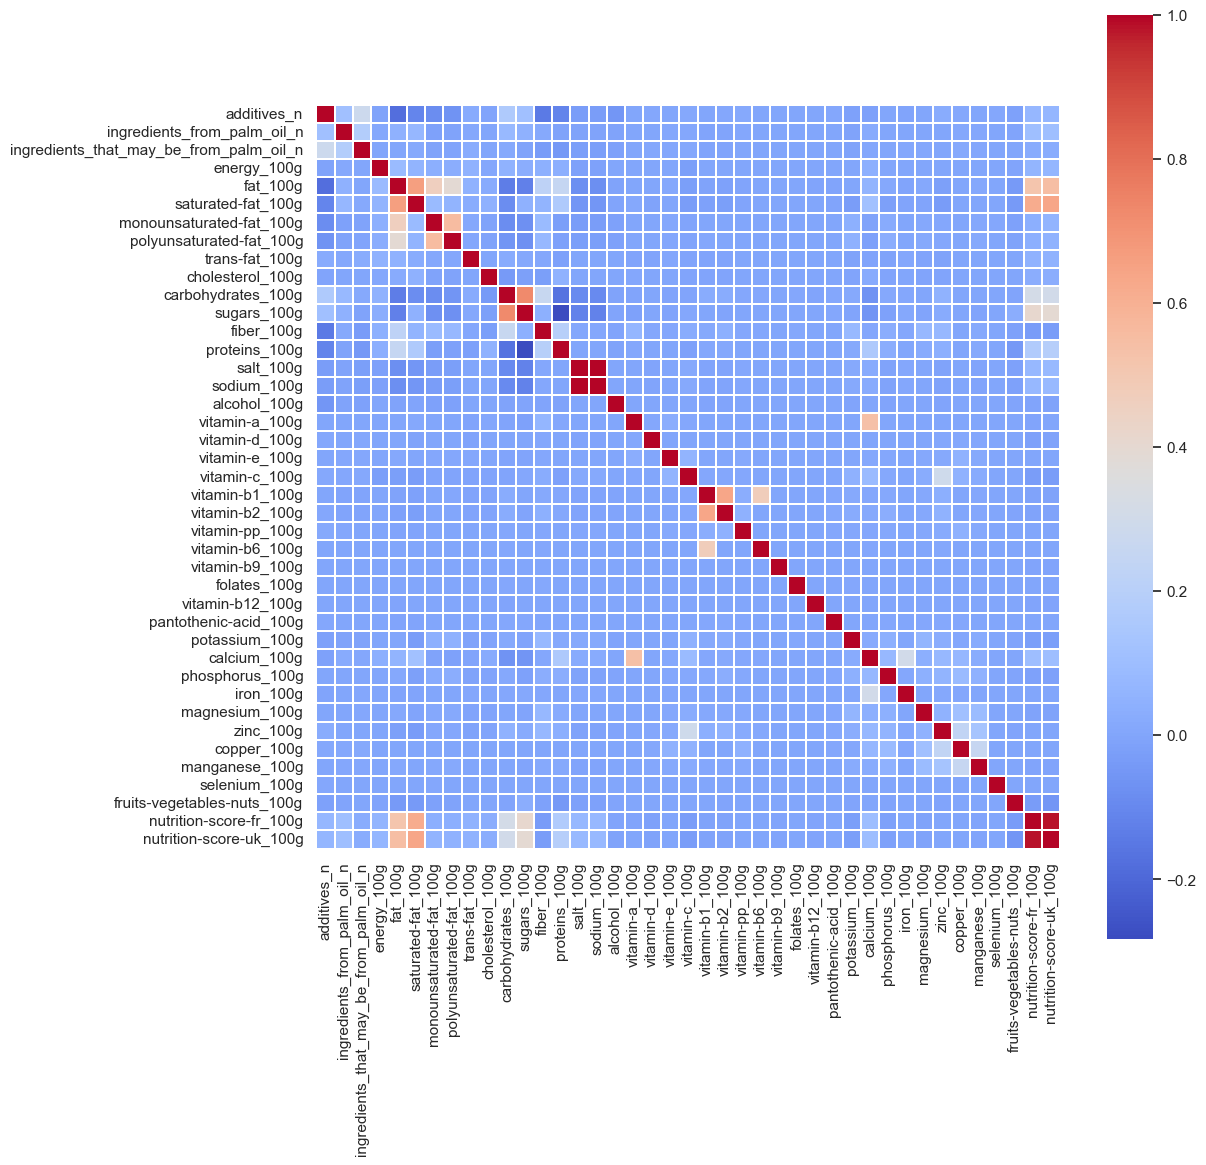

In [17]:
correlations = df.corr(numeric_only=True)
figure = plt.figure(figsize=(12,12))
sns.heatmap(correlations, square=True, linewidths=0.01, cmap="coolwarm")
plt.show()

On verifie si la vitamine A a une relation linéaire au calcium

<Axes: xlabel='vitamin-a_100g', ylabel='calcium_100g'>

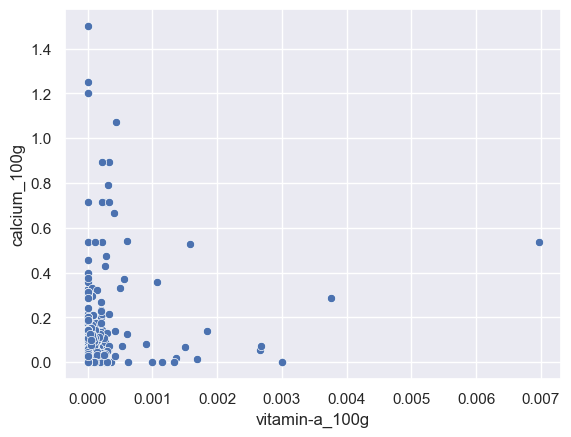

In [18]:
sns.scatterplot(data=df.sample(n=1000), x='vitamin-a_100g', y='calcium_100g')

Pas de correlation lineaire entre vitamine A et calcium

Essayons avec les graisses et graisses saturées

<Axes: xlabel='fat_100g', ylabel='saturated-fat_100g'>

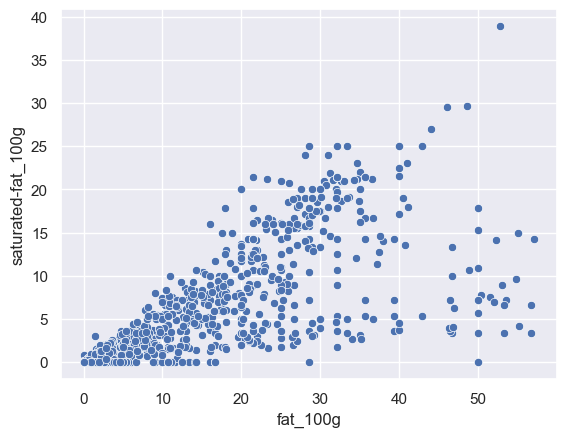

In [19]:
sample = df[~df['saturated-fat_100g'].isna() & ~df['fat_100g'].isna() & (df['fat_100g'] < 60)]
sample = sample.sample(n=1000)
sns.scatterplot(data=sample, y='saturated-fat_100g', x='fat_100g')

Il y a bien une correlation qui se desine, on va exploiter celle-ci pour imputer mutuellement les valeurs

In [20]:
regr = linear_model.LinearRegression()
regr.fit(np.array(sample['fat_100g'].to_list()).reshape(-1, 1), np.array(sample['saturated-fat_100g'].to_list()).reshape(-1, 1))

LinearRegression()

<function matplotlib.pyplot.show(close=None, block=None)>

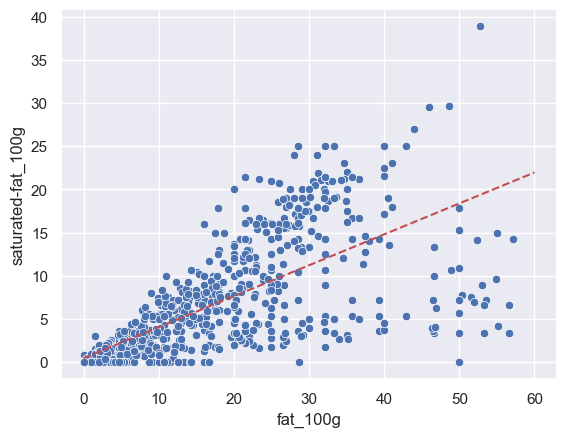

In [21]:
sns.scatterplot(data=sample, y='saturated-fat_100g', x='fat_100g')
plt.plot([0, 60], [regr.intercept_, regr.intercept_ + regr.coef_[0] * 60], '--', c='r')
plt.show

Imputation des graisses saturées par la valeur des graisses si présente et vice-versa

In [22]:
saturated_na = df['saturated-fat_100g'].isna() & ~df['fat_100g'].isna()
serie = df.loc[saturated_na, 'fat_100g']
serie = np.clip(serie * regr.coef_[0] + regr.intercept_, 0, 100)
df.loc[saturated_na, 'saturated-fat_100g'] = serie

fat_na = df['fat_100g'].isna() & ~df['saturated-fat_100g'].isna()
serie = df.loc[fat_na, 'saturated-fat_100g']
serie = np.clip((serie - regr.intercept_) / regr.coef_[0], 0, 100)
df.loc[fat_na, 'fat_100g'] = serie


In [23]:
for col in numeric_cols:
    df.loc[df[col].isna(), col] = df.loc[:, col].mean()

In [24]:
df.isna().mean().sort_values(ascending=False)[:60]

ingredients_from_palm_oil_tags                0.980026
ingredients_that_may_be_from_palm_oil_tags    0.953509
origins_tags                                  0.940874
origins                                       0.940789
first_packaging_code_geo                      0.940123
cities_tags                                   0.935469
traces_fr                                     0.913464
traces_tags                                   0.913464
traces                                        0.913464
emb_codes_tags                                0.907720
emb_codes                                     0.907715
allergens                                     0.897451
manufacturing_places_tags                     0.887594
manufacturing_places                          0.887585
labels                                        0.861122
labels_fr                                     0.860872
labels_tags                                   0.860872
stores                                        0.843046
generic_na

### Analyse des colonnes countries

In [25]:
df.loc[:, 'countries_fr'].dropna().unique()[:10]

array(['États-Unis', 'France,États-Unis', 'Canada', 'France', 'Allemagne',
       'Royaume-Uni', 'Espagne', 'France,Royaume-Uni',
       'Belgique,France,Pays-Bas,Royaume-Uni', 'Canada,États-Unis'],
      dtype=object)

Certaine valeurs apparaissent plusieurs fois, je crée et utilise une fonction generique qui renverra une serie basée sur une colonne avec leur nombre d'apparitions

Text(0.5, 1.0, 'Nombre de produits par pays')

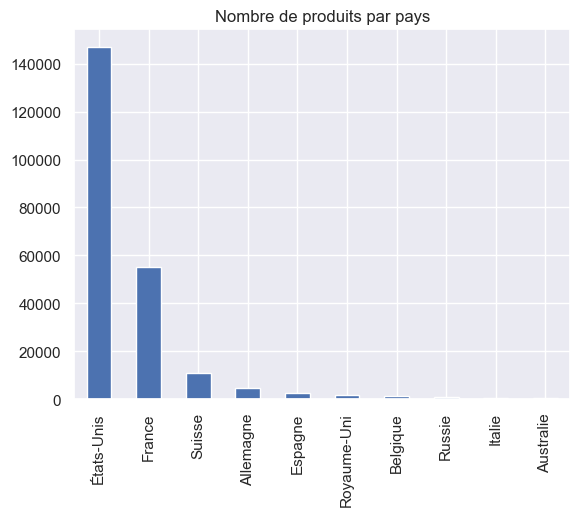

In [26]:
extract_serie(df, 'countries_fr')[0:10].plot.bar()
plt.title('Nombre de produits par pays')

### Analyse des colonnes categories

Text(0.5, 1.0, 'Nombre de produits par categorie')

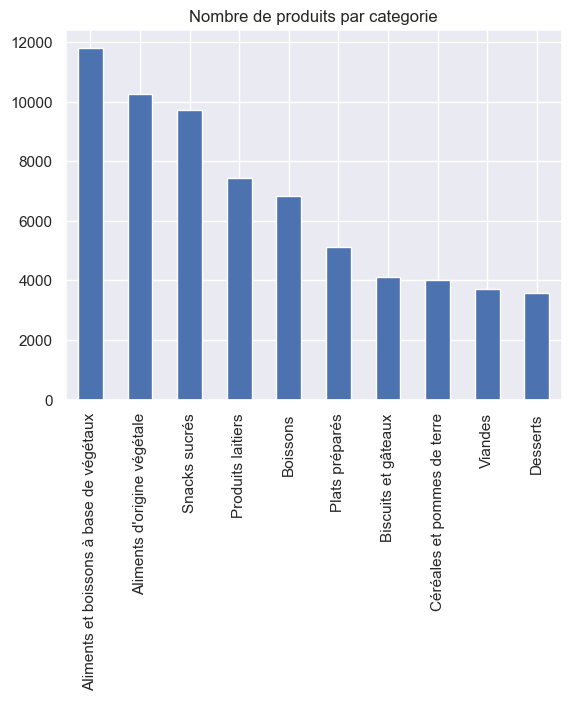

In [27]:
extract_serie(df, 'categories_fr')[0:10].plot.bar()
plt.title('Nombre de produits par categorie')

In [28]:
df = df[ ['product_name', 'nutrition_grade_fr'] + numeric_cols.to_list()]
df = df.loc[~df['product_name'].isna()]

In [29]:
df.head()

,product_name,nutrition_grade_fr,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,...,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,selenium_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
1,Banana Chips Sweetened (Whole),d,0.0,0.0,0.0,2243.0,28.57,28.570000,0.0,0.0,...,0.0,0.001290,0.0,0.0,0.0,0.0,0.0,0.0,14.000000,14.000000
2,Peanuts,b,0.0,0.0,0.0,1941.0,17.86,0.000000,0.0,0.0,...,0.0,0.001290,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,Organic Salted Nut Mix,d,0.0,0.0,0.0,2540.0,57.14,5.360000,0.0,0.0,...,0.0,0.005140,0.0,0.0,0.0,0.0,0.0,0.0,12.000000,12.000000
4,Organic Polenta,NaN,0.0,0.0,0.0,1552.0,1.43,0.984952,0.0,0.0,...,0.0,0.003444,0.0,0.0,0.0,0.0,0.0,0.0,11.699633,11.641361
5,Breadshop Honey Gone Nuts Granola,NaN,0.0,0.0,0.0,1933.0,18.27,1.920000,0.0,0.0,...,0.0,0.003460,0.0,0.0,0.0,0.0,0.0,0.0,11.699633,11.641361


In [30]:
infos(df)

A ce stade le dataset contient 220818 lignes et 43 colonnes. (conso mémoire 0.1Gb)


In [31]:
df.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,trans-fat_100g,cholesterol_100g,...,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,selenium_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,220818.000000,220818.000000,220818.000000,2.208180e+05,220818.000000,220818.000000,220818.000000,220818.000000,220818.000000,220818.000000,...,220818.000000,220818.000000,220818.000000,220818.000000,220818.000000,220818.000000,220818.000000,220818.000000,220818.000000,220818.000000
mean,2.153618,0.021782,0.060511,1.230836e+03,14.735116,5.454621,1.051468,0.626117,0.074448,0.021533,...,0.005902,0.003444,0.003397,0.000100,0.000277,0.000013,0.000016,0.283263,11.694352,11.636577
std,2.446926,0.139958,0.265465,6.976744e+03,18.464385,7.952677,6.190543,3.939240,0.655809,0.254972,...,0.189860,0.162164,0.161050,0.003105,0.088084,0.001136,0.007600,3.882737,7.015302,7.128642
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,4.940000e+02,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000840,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,6.000000
50%,2.000000,0.000000,0.000000,1.231867e+03,8.620000,2.380000,0.000000,0.000000,0.000000,0.021528,...,0.000000,0.003444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.699633,11.641361
75%,3.000000,0.000000,0.000000,1.770000e+03,23.000000,7.700000,0.000000,0.000000,0.074483,0.021528,...,0.000000,0.003444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,16.000000
max,31.000000,2.000000,6.000000,3.251373e+06,100.000000,100.000000,100.000000,98.000000,100.000000,95.238000,...,84.900000,50.000000,39.500000,1.050000,37.600000,0.367000,3.571429,100.000000,40.000000,40.000000


In [32]:
df.isna().mean().sort_values(ascending=False)[:10]

nutrition_grade_fr       0.18229
vitamin-c_100g           0.00000
vitamin-b1_100g          0.00000
vitamin-b2_100g          0.00000
vitamin-pp_100g          0.00000
vitamin-b6_100g          0.00000
vitamin-b9_100g          0.00000
folates_100g             0.00000
vitamin-b12_100g         0.00000
pantothenic-acid_100g    0.00000
dtype: float64

In [71]:
df.describe().T.sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
energy_100g,220818.0,1.230836e+03,6976.743674,0.0,494.00000,1231.866837,1770.000000,3.251373e+06
carbohydrates_100g,220818.0,3.330892e+01,28.098842,0.0,7.03000,29.410000,57.140000,1.000000e+02
sugars_100g,220818.0,1.835313e+01,21.339172,0.0,2.10000,10.620000,26.670000,1.000000e+02
fat_100g,220818.0,1.473512e+01,18.464385,0.0,0.00000,8.620000,23.000000,1.000000e+02
nutrition-score-fr_100g,220818.0,1.169435e+01,7.015302,0.0,6.00000,11.699633,16.000000,4.000000e+01
nutrition-score-uk_100g,220818.0,1.163658e+01,7.128642,0.0,6.00000,11.641361,16.000000,4.000000e+01
proteins_100g,220818.0,7.034875e+00,8.252784,0.0,0.50000,4.760000,9.680000,1.000000e+02
saturated-fat_100g,220818.0,5.454621e+00,7.952677,0.0,0.40000,2.380000,7.700000,1.000000e+02
fiber_100g,220818.0,2.499318e+00,3.474844,0.0,0.00000,2.499053,2.500000,1.000000e+02
additives_n,220818.0,2.153618e+00,2.446926,0.0,0.00000,2.000000,3.000000,3.100000e+01


<Axes: >

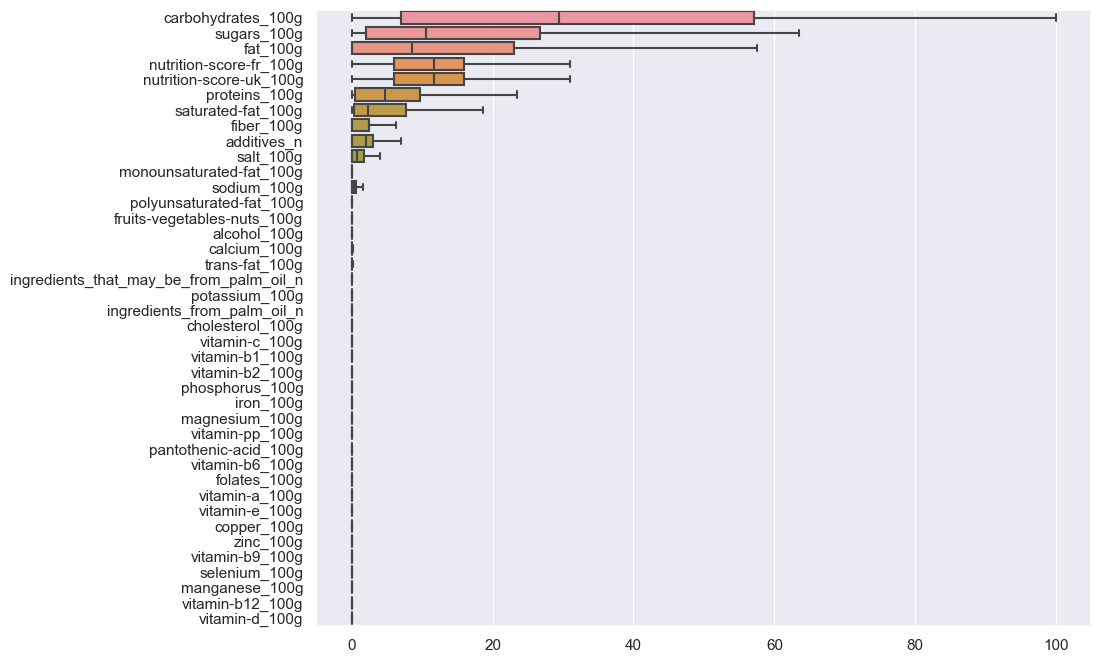

In [80]:
df_box = df.loc[:, df.columns != 'energy_100g']
plt.figure(figsize=(10,8))
order = df_box.describe().T.sort_values(by='mean', ascending=False).index.tolist()
sns.boxplot(data=df.loc[:, df.columns != 'energy_100g'], showfliers=False, orient='h', order=order)

### PCA

In [82]:
values = df[order[:11]].values
scaled_values = scale(values)

In [83]:
scaled_df = pd.DataFrame(scaled_values)
scaled_df.describe().round(2).loc[['mean', 'std'], :]

,0,1,2,3,4,5,6,7,8,9,10
mean,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [85]:
result = acp(scaled_values=scaled_values, n_components=6)

In [86]:
result['pca'].explained_variance_ratio_

array([0.27941947, 0.19243563, 0.11316236, 0.10298207, 0.09116713,
       0.07992148])

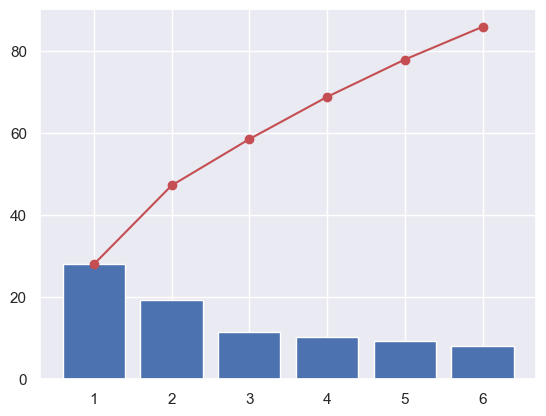

In [87]:
acp_eboulis(pca=result['pca'])